## Determine max distance between sensors and each point on the planet
This distance map is used to computes the probability of detecting a given event across an entire sensor network

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import compute_network_shapes_CPUs as cns

### Grid source locations

In [2]:
reload(cns)

dlon = 2.
lats, lons = np.arange(-90, 89, dlon/2.), np.arange(-180, 179, dlon)
LATS, LONS, shape_init = cns.get_grid(lats, lons)

In [3]:
reload(cns)
polys = cns.get_polys(LONS, LATS, dlon, R0=6052000)

### Balloons

In [415]:
import compute_network_shapes_CPUs as cns
import proba_modules as pm
reload(cns)
reload(pm)

file_curve = './data/GF_data/GF_Dirac_1Hz_all_wfreq.csv'
dict_scaling = dict(R0=6052000, sigma_balloon=1e-2, boost_SNR=dict(dayglow=1, nightglow=10.), photons_dayglow=3.5e5, alpha_dayglow=1e-5, photons_nightglow=2e4, beta=1.,)
freq = [1e-2, 1e-1, 1.]
f_alt_scaling_dayglow, f_alt_scaling_nightglow, TL_new_v, TL_new_p = cns.get_airglow_scaling(file_curve, freq, **dict_scaling)

100%|██████████| 3/3 [00:02<00:00,  1.44it/s]


In [385]:
reload(cns)

file_curve = './data/GF_data/GF_Dirac_1Hz_all_wfreq.csv'
dict_scaling = dict(R0=6052000, sigma_balloon=1e-2, boost_SNR=25., photons_dayglow=3.5e5, alpha_dayglow=1e-5, photons_nightglow=2e4, beta=1., TL_new_v=TL_new_v, TL_new_p=TL_new_p, m0=4.)
freq = [1e-2, 1e-1, 1.]
f_alt_scaling_dayglow, f_alt_scaling_nightglow, TL_new_v, TL_new_p = cns.get_airglow_scaling(file_curve, freq, **dict_scaling)

100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


In [437]:
reload(cns)

dlon_stations = 2.
lats, lons = np.arange(-90, 89, dlon_stations/2.), np.arange(-180, 179, dlon_stations)
dict_stations = dict(offsets=[], use_airglow=False, use_only_airglow=True, fixed_stations=dict(), add_velocity=True, vel_baloon=0.2, vel_imager=0.36)
lats_stations, lons_stations, id_scenario, id_stat = cns.get_stations(lats, lons, **dict_stations)
lats_stations.shape

(32220, 1)

In [438]:
reload(cns)

opt_dist = dict(s_cluster=100, use_airglow=dict_stations['use_airglow'], which_stat_is_airglow=0, lon_0_airglow=dict(nightglow=180., dayglow=0.), radius_airglow=dict(nightglow=60., dayglow=70.), radius_view=60., airglow_considered=['nightglow','dayglow'])
max_dist = dict()
for period, f_alt_scaling_nightglow_period in f_alt_scaling_nightglow.items():
    f_alt_scaling = dict(nightglow=f_alt_scaling_nightglow_period, dayglow=f_alt_scaling_dayglow[period])
    #f_alt_scaling = dict(nightglow=f_alt_scaling_nightglow_period, dayglow=f_alt_scaling_nightglow_period)
    max_dist_loc = cns.get_max_dist(lats_stations, lons_stations, LATS, LONS, id_scenario, id_stat, f_alt_scaling=f_alt_scaling, **opt_dist)
    max_dist[period] = max_dist_loc.copy()

  0%|          | 0/323 [00:00<?, ?it/s]

c:\Users\quentin\Documents\2024_Venus_Detectability\compute_network_shapes_CPUs.py:156: RuntimeWarning: invalid value encountered in sqrt
  a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1_rad) * np.cos(lats_rad) * np.sin(dlon / 2.0) ** 2
100%|██████████| 323/323 [05:00<00:00,  1.08it/s]


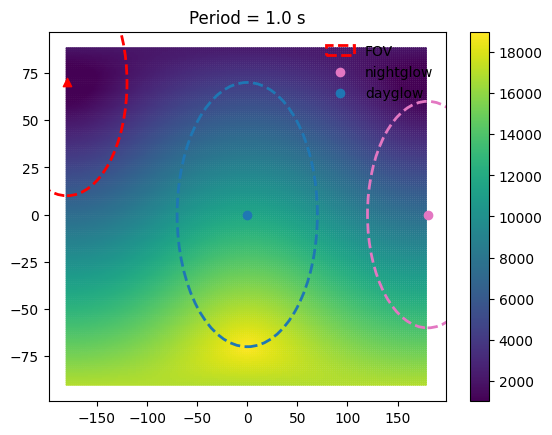

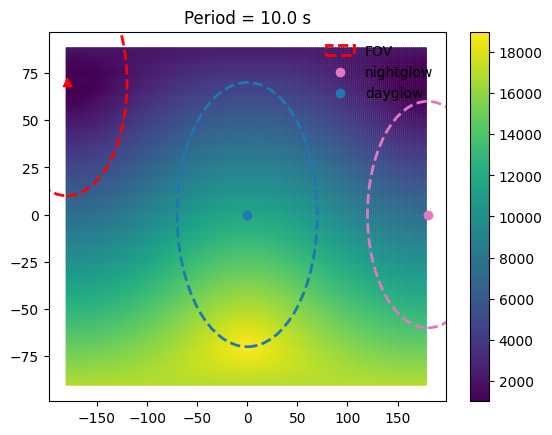

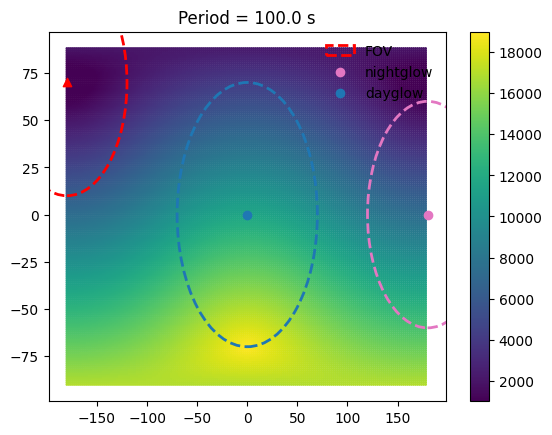

In [440]:
def plot_one_max_dist(id, period, max_dist_loc, vmin=1e3, vmax=19e3):

    plt.figure()
    sc = plt.scatter(LONS, LATS, c=max_dist_loc[id,:]/1e3, s=1, vmin=vmin, vmax=vmax)
    plt.colorbar(sc)
    plt.scatter(lons_stations[id,:], lats_stations[id,:], c='red', marker='^')
    circle = plt.Circle((lons_stations[id,-1], lats_stations[id,-1]), opt_dist['radius_view'], edgecolor='red', ls='--', facecolor='none', linewidth=2, label='FOV')
    plt.gca().add_artist(circle)

    colors = dict(dayglow='tab:blue', nightglow='tab:pink')
    for airglow, lon0 in opt_dist['lon_0_airglow'].items():
        radius = opt_dist['radius_airglow'][airglow]
        plt.scatter(lon0, 0., marker='o', label=airglow, color=colors[airglow])
        circle = plt.Circle((lon0, 0.), radius, edgecolor=colors[airglow], ls='--', facecolor='none', linewidth=2,)
        plt.gca().add_artist(circle)

    plt.title(f'Period = {period} s')
    plt.legend(frameon=False)

id = 160
for period, max_dist_loc in max_dist.items():
    plot_one_max_dist(id, period, max_dist_loc)

In [8]:
#max_dist = np.load('./max_dist.npy', mmap_mode='r')
with open('./max_dist_2_4.npy', 'wb') as f:
    np.save(f, max_dist)

In [441]:
plot = False
R0 = 6052000
thresholds = np.arange(10000, np.pi*R0/1.001, 5e5)[:]/1e3
#gdf = compute_surfaces(LATS, LONS, lats_stations, lons_stations, polys, plot, R0, max_dist)
gdf = dict()
for period, max_dist_loc in max_dist.items():
    gdf[period] = cns.compute_surfaces_CPUs(thresholds, LATS, LONS, lats_stations, lons_stations, polys, plot, R0, max_dist_loc, nb_CPU=1)
    #gdf.to_file("./network_10_20.shp")
    #break

Running serial


  0%|          | 14/32220 [00:43<27:59:54,  3.13s/it]


KeyboardInterrupt: 

In [431]:
import pandas as pd
gdf_all = pd.DataFrame()
for period, gdf_loc in gdf.items():
    gdf_loc['period'] = period
    gdf_all = pd.concat([gdf_all, gdf_loc])
gdf_all.reset_index(drop=True, inplace=True)

In [435]:
file = f"./data/airglow_shp/network_SNRnight{dict_scaling['boost_SNR']['nightglow']}_SNRday{dict_scaling['boost_SNR']['dayglow']}.shp"
gdf_all.to_file(file)

C:\Users\quentin\AppData\Local\Temp\ipykernel_9300\3504460055.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_all.to_file(file)


### Airglow

100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


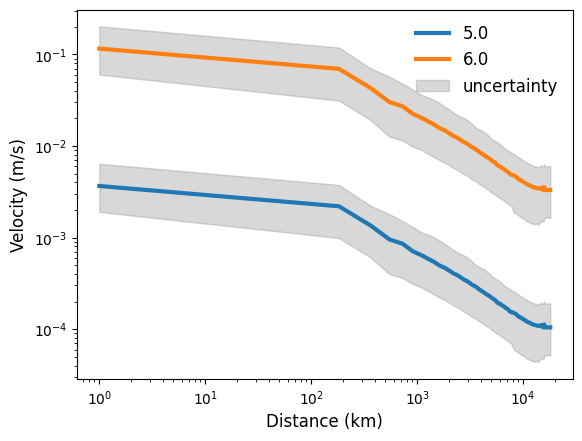

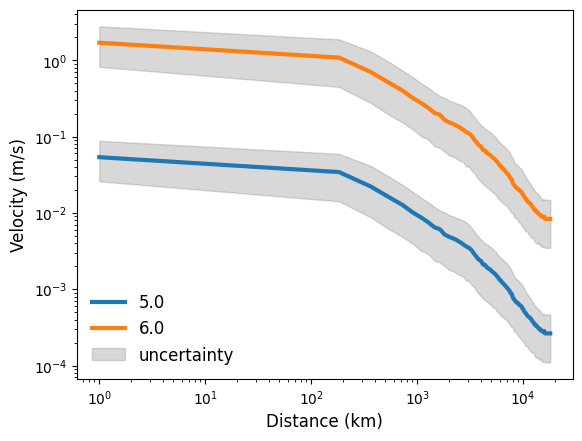

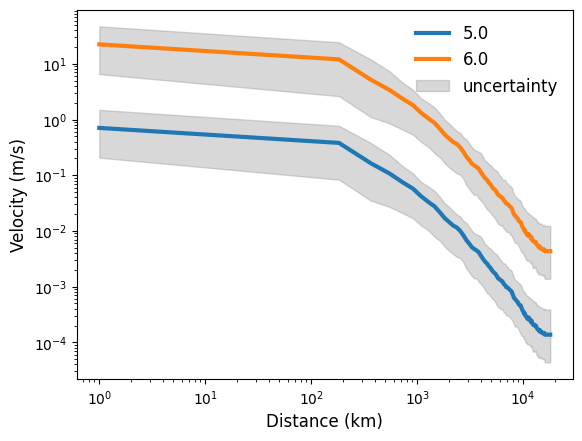

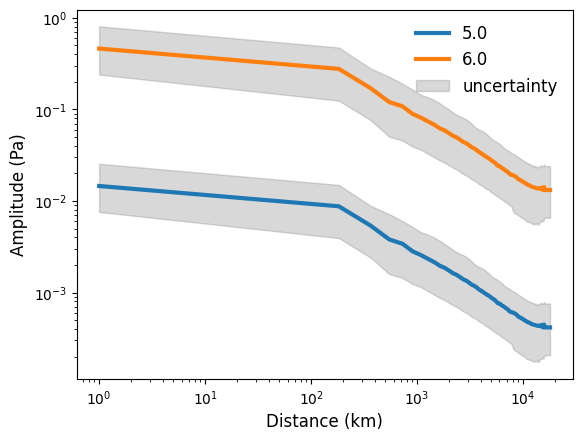

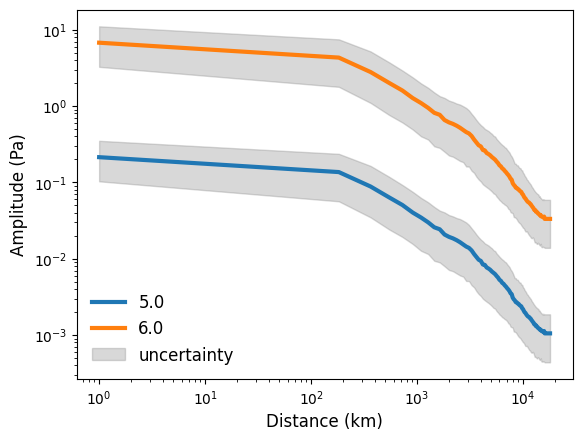

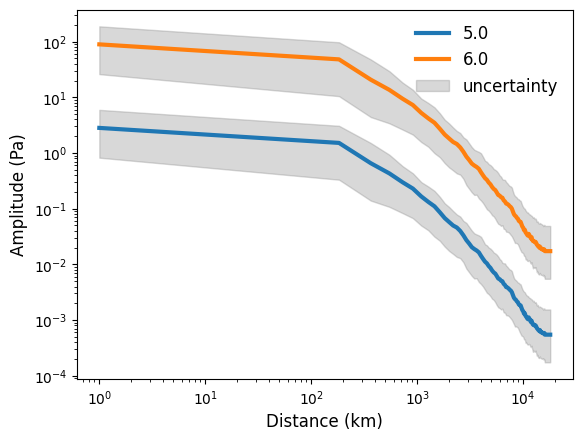

In [197]:
import compute_network_shapes_CPUs as cns
import proba_modules as pm
reload(cns)
reload(pm)

file_curve = './data/GF_data/GF_Dirac_1Hz_all_wfreq.csv'
dict_scaling = dict(R0=6052000, sigma_balloon=1e-2, boost_SNR=1., photons_dayglow=3.5e5, alpha_dayglow=1e-5, photons_nightglow=2e4, beta=1.,)
freq = [1e-2, 1e-1, 1.]
f_alt_scaling_dayglow, f_alt_scaling_nightglow = cns.get_airglow_scaling(file_curve, freq, **dict_scaling)

In [49]:
reload(cns)

dlon_stations = 5.
lats, lons = np.arange(-90, 89, dlon/2.), np.arange(-180, 179, dlon)
lats_stations, lons_stations, id_scenario, id_stat = cns.get_stations(lats, lons, offsets=[], fixed_stations=dict(scenario_1=[[0., 0.]]))

In [199]:
reload(cns)
max_dist = dict()
for period, f_alt_scaling in f_alt_scaling_nightglow.items():
    max_dist[period] = cns.get_max_dist(lats_stations, lons_stations, LATS, LONS, id_scenario, id_stat, s_cluster=100, use_airglow=True, which_stat_is_airglow=1, alt_scaling=f_alt_scaling)

TypeError: get_max_dist() got an unexpected keyword argument 'R_airglow'

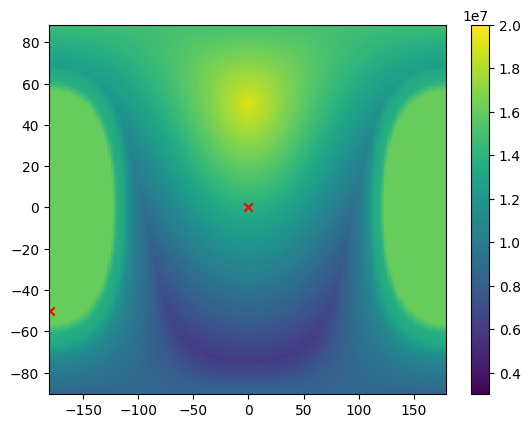

In [105]:
plt.figure()
id = 40
sc = plt.pcolormesh(lons, lats, max_dist[id,:].reshape(shape_init).T, vmin=0.3e7, vmax=2.e7)
plt.colorbar(sc)
plt.scatter(lons_stations[id,:], lats_stations[id,:], marker='x', color='red')

### Compute surface ratios

In [9]:
reload(cns)
plot = False
R0 = 6052000
thresholds = np.arange(10000, np.pi*R0/1.001, 5e5)[:]/1e3
gdf = cns.compute_surfaces_CPUs(thresholds, LATS, LONS, lats_stations, lons_stations, polys, plot, R0, max_dist, nb_CPU=1)

Running serial


  0%|          | 4/32220 [00:13<29:15:30,  3.27s/it]


KeyboardInterrupt: 

: 

In [29]:
gdf.to_file("./airglow_shp/airglow.shp")

C:\Users\quentin\AppData\Local\Temp\ipykernel_16484\120095355.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file("./airglow_shp/airglow.shp")


In [31]:
import geopandas as gpd
gdf2=gpd.read_file(f"./airglow_shp/airglow.shp")